# 6.임베딩 내 편향성 알아보기

1. 워드 임베딩의 편향성
2. WEAT를 통한 편향성 측정
3. WEAT 구현하기
4. 사전학습된 Word Embedding에 WEAT 적용
5. 직접 만드는 Word Embedding에 WEAT 적용(1)
6. 직접 만드는 Word Embedding에 WEAT 적용(2)
7. 프로젝트 : 모든 장르 간 편향성 측정해 보기

[Predictive policing algorithms are racist. They need to be dismantled.](https://www.technologyreview.com/2020/07/17/1005396/predictive-policing-algorithms-racist-dismantled-machine-learning-bias-criminal-justice/)   
['Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings'](https://arxiv.org/pdf/1607.06520.pdf)   
[Semantics derived automatically from language corpora necessarily contain human biases (Word Embedding Association Test (WEAT))](https://arxiv.org/pdf/1608.07187.pdf)

target과 attribute 데이터셋들을 통해 개념축들을 얻고, 그 개념축들의 거리에 따라 편향성을 체크   
[Text Embedding Models Contain Bias. Here's Why That Matters.](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html)   
![weat](https://4.bp.blogspot.com/-KHaWu25QTnY/WtEARsgv0uI/AAAAAAAAFDY/Rx6WdfTYT-sq2_IU9uBX_Tfzb35pWJp2gCLcBGAs/s1600/WEAT_table_1600_ppi.png)

## WEAT 구현

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의한다.   
단어 셋을 정할 때는 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야 한다.

- targets
  - X set(꽃) : 장미, 튤립, 백합, 데이지
  - Y set(곤충) : 거미, 모기, 파리, 메뚜기

- attributes
  - A set(유쾌) : 사랑, 행복, 웃음
  - B set(불쾌) : 재난, 고통, 증오

In [28]:
# TODO: 여기서 크기가 같아야 함은 사이즈? 벡터 크기? 

# 꽃
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}

# 곤충
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}

# 유쾌
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}

# 불쾌
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [27]:
def set_mag(dataset):
    lst = []
    for i, value in dataset.items():
        lst.append(np.linalg.norm(value))
    return sum(lst)/len(lst)
        
print(set_mag(target_X))
print(set_mag(target_Y))

6.881667921042263
6.3657336324081095


In [19]:
lst = np.array([])
for i, value in target_X.items():
    np.append(lst, np.linalg.norm(value))
print(lst)

[]


In [3]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [4]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [5]:
# 코사인 유사도 계산
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

# s('장미', A, B) 를 계산
print(s(target_X['장미'], A, B))

0.6457646122337399


WEAT score값이 양수이므로, target_X에 있는 '장미'라는 단어는 attribute_B(불쾌)보다 attribute_A(유쾌)와 더 가깝다는 것을 알 수 있다.

In [29]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


WEAT score가 음수가 나왔으므로, '거미'는 attribute_B와 더 가깝다는 것을 알 수 있다.

In [32]:
# target_X와 attribute_A, attribute_B 사의의 평균값
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


In [33]:
# target_Y와 attribute_A, attribute_B 사이의 평균값
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


WEAT score 식   
![weat](https://media.vlpt.us/images/guide333/post/a09d3fba-2991-4d5e-9d07-4cb58f064f12/Screenshot%20from%202021-04-13%2013-22-55.png)   

In [34]:
# WEAT score 함수
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


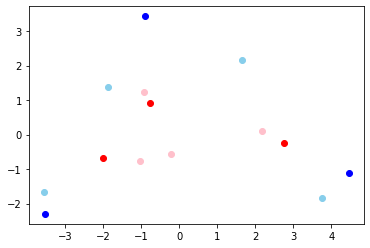

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝다

## 사전 학습된 워드 임베딩에 WEAT 적용
[GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download)   
pip install gensim

In [39]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# w2v를 사용하다가 메모리 부족이 발생할 수 있다. 이때는 워드 임베딩 내 300만 개의 단어 중 자주 쓰는 단어 50만 개만 꺼내어 사용한다
# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [40]:
w2v

In [41]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


w2v에는 limit으로 지정한 갯수(디폴트는 3,000,000개)의 단어가 있고, 각 단어는 300차원을 갖는다

In [42]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [43]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [44]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [45]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

In [46]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [47]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

In [48]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

In [49]:
target_X = ['keyboard', 'monitor', 'camera', 'speaker', 'headphone']
target_Y = ['book', 'pencil', 'clip', 'tape', 'note']
attribute_A = ['computer', 'phone', 'screen', 'remote']
attribute_B = ['pen', 'paper', 'sticker', 'case']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.7586296

In [50]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


## 직접 만드는 워드 임베딩에 WEAT 적용

1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
4. embedding model과 단어 셋으로 WEAT score 구해보기

영화 시놉시스 데이터셋으로 형태소 분석기를 통해 명사들 추출   
 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보   
[synopsis.zip(KOBIS)](https://d3s0tskafalll9.cloudfront.net/media/documents/synopsis.zip)

In [52]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장한다.   
$ pip install konlpy

In [53]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [54]:
print(len(tokenized))

71156


추출된 결과로 임베딩 모델 만들기

In [55]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8769224286079407),
 ('다큐멘터리', 0.8415693044662476),
 ('드라마', 0.8120982646942139),
 ('영화로', 0.8038495779037476),
 ('코미디', 0.7961021661758423),
 ('주제', 0.7926156520843506),
 ('감동', 0.7815698385238647),
 ('스토리', 0.7791649699211121),
 ('형식', 0.7770284414291382),
 ('시대극', 0.7761639356613159)]

In [56]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.710620105266571),
 ('만남', 0.7052522301673889),
 ('운명', 0.6923129558563232),
 ('행복', 0.6886546611785889),
 ('일천', 0.6861551403999329),
 ('진심', 0.6840518116950989),
 ('애정', 0.6814039945602417),
 ('우정', 0.6793522238731384),
 ('만인', 0.6781465411186218),
 ('이별', 0.6777418255805969)]

In [57]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9120622873306274),
 ('영감', 0.8848069906234741),
 ('영화감독', 0.88200443983078),
 ('예술가', 0.8721357583999634),
 ('배우', 0.87180495262146),
 ('공연', 0.8691583275794983),
 ('팬', 0.8672571182250977),
 ('뮤지션', 0.8649891018867493),
 ('연기자', 0.8647129535675049),
 ('캐스팅', 0.8630933165550232)]

### TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어주어야 한다.   
targets_X, targets_Y, attribute_A, attribute_B   
두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정한다.   

- 영화 구분(target)
    - synopsis_art.txt : 예술영화
    - synopsis_gen.txt : 일반영화(상업영화)
    - 그 외는 독립영화 등으로 분류됩니다.

- 장르 구분(attribute)
    - synopsis_SF.txt: SF
    - synopsis_가족.txt: 가족
    - synopsis_공연.txt: 공연
    - synopsis_공포(호러).txt: 공포(호러)
    - synopsis_기타.txt: 기타
    - synopsis_다큐멘터리.txt: 다큐멘터리
    - synopsis_드라마.txt: 드라마
    - synopsis_멜로로맨스.txt: 멜로로맨스
    - synopsis_뮤지컬.txt: 뮤지컬
    - synopsis_미스터리.txt: 미스터리
    - synopsis_범죄.txt: 범죄
    - synopsis_사극.txt: 사극
    - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
    - synopsis_성인물(에로).txt: 성인물(에로)
    - synopsis_스릴러.txt: 스릴러
    - synopsis_애니메이션.txt: 애니메이션
    - synopsis_액션.txt: 액션
    - synopsis_어드벤처.txt: 어드벤처
    - synopsis_전쟁.txt: 전쟁
    - synopsis_코미디.txt: 코미디
    - synopsis_판타지.txt: 판타지   
   
여기서는 드라마와 액션 장르를 attribute로 두어 WEAT score를 확인한다.

In [58]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt' # 예술영화
gen_txt = 'synopsis_gen.txt' # 상업영화

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [59]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


여기서, art_text를 처리하여 art 단어 리스트로부터 적절한 단어들을 골라낸다 (TF_IDF)

In [60]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [61]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [62]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

# 상위 100개 단어 추출
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

하지만, 양쪽으로 중복된 단어가 너무 많다. 상위 100개 단어들 중 중복된 단어를 제외하고 상위 15개 단어를 추출한다.

In [63]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [64]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [65]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


이번엔 장르별 (attribute) 단어를 추출하자 (드라마, 액션, 코미디, 전쟁, 공포(호러))

In [66]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [67]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [68]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [69]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


중복된게 조금 있지만 target 추출 때보다는 적다. 이대로 쓴다!

### WEAT score 구하기

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구한다.   
구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담는다.

In [70]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [71]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])
# matrix에 채운다
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [72]:
# WEAT score들을 확인해보자
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

드라마 멜로로맨스 -0.828535
드라마 액션 -0.021339249
드라마 코미디 0.011755267
드라마 전쟁 0.41974625
드라마 공포(호러) -0.17717046
멜로로맨스 액션 0.76183146
멜로로맨스 코미디 0.9004537
멜로로맨스 전쟁 0.7919471
멜로로맨스 공포(호러) 0.75278276
액션 코미디 0.03488517
액션 전쟁 0.5896381
액션 공포(호러) -0.21845411
코미디 전쟁 0.4738904
코미디 공포(호러) -0.2939395
전쟁 공포(호러) -0.5458616


- 예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
- 예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 코디미는 일반 영화와 가깝다고 볼 수 있습니다.
- 예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있습니다.

<AxesSubplot:>

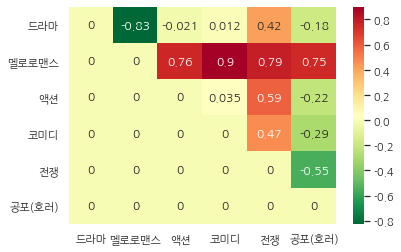

In [73]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax